**DETECCION DE ANOMALIAS USANDO ISOLATION FOREST**
  - ISOLATION FOREST Devuelva la puntuación de anomalía de cada muestra utilizando el algoritmo  IsolationForest

- IsolationForest 'aísla' las observaciones seleccionando aleatoriamente una característica y luego seleccionando aleatoriamente un valor dividido entre los valores máximo y mínimo de la característica seleccionada.

**LIBERIAS**

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import plotly.express as px
from datetime import datetime
from sklearn.ensemble import IsolationForest

mpl.rcParams['figure.figsize']=(11,9)
import warnings
warnings.filterwarnings("ignore")


In [10]:
df=pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv")

In [11]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [12]:
df.info()
#tenemos que conertir tiemstamo a date y no se detecta valores nulos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [16]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [18]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [25]:
#set index timestamp
df=df.set_index('timestamp').resample('H').mean().reset_index()
df.head()

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [26]:
#vamos a dibujar la serie de tiempo 
#https://plotly.com/python

fig = px.line(df, x="timestamp", y="value", title='demanda de taxi NYc')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**A simple vista notamos que tenemos anomalia contextual en 1 enero debido a la noche vieja , y 2 nov  a la 01:00 valores alto y valor bajo a las 07:00 creo que hay algun evento , en contraste tenemos picos v¡bajos en noche buena , y dia de action  de gracia**

In [34]:
pd.Categorical(df.timestamp.dt.strftime('%A'))

['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', ..., 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday']
Length: 5160
Categories (7, object): ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
                         'Wednesday']

In [55]:
#vamos a crear mas columnas de tiempo para analizar bien la serie de tiempo 
#añadiremos a l hora , el dia de la semana como categoria 
#chceck lista de parametros de strtime ->> https://strftime.org/
df['hora']=df.timestamp.dt.hour
# con esto abajo sin especificar el la serie de dias al dibjar el graficos salen los  dias de semana  desordenados solucion
#df['dia_semana']=pd.Categorical(df.timestamp.dt.strftime('%A'))
df['dia_semana']=pd.Categorical(df.timestamp.dt.strftime('%A'),categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   5160 non-null   datetime64[ns]
 1   value       5160 non-null   float64       
 2   hora        5160 non-null   int64         
 3   dia_semana  4416 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 126.4 KB


In [49]:
df.head()

,timestamp,value,hora,dia_semana
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday


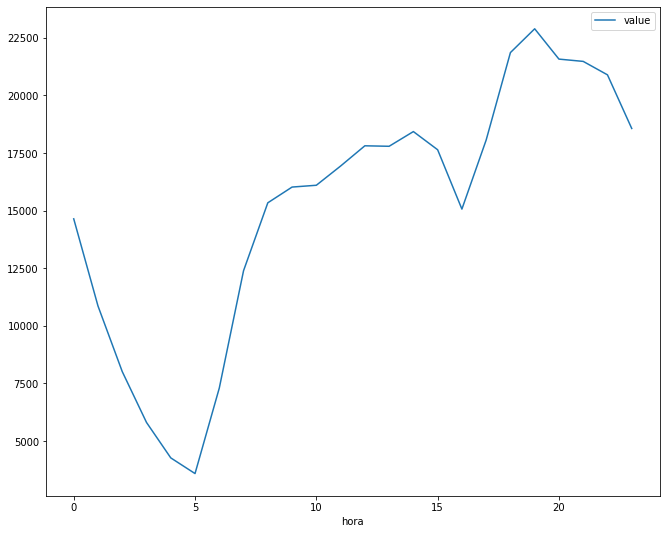

In [50]:
#vamos a crear unos graficos respecto a la hora o el dia de la semana 
df[['value','hora']].groupby('hora').mean().plot()

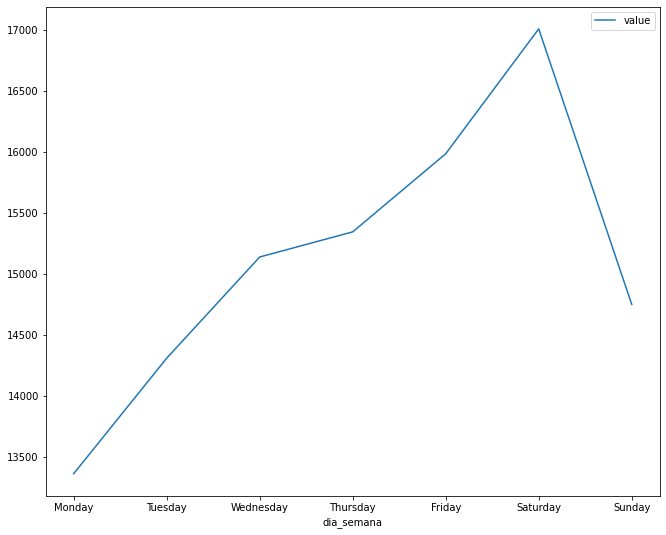

In [56]:
df[['value','dia_semana']].groupby('dia_semana').mean().plot()

In [67]:
df.groupby(['hora','dia_semana']).mean()['value'].unstack()

dia_semana,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hora,,,,,,,
0,8020.283333,8483.709677,10544.661290,12698.500000,15941.048387,22993.064516,23898.733333
1,4749.750000,5028.193548,6272.629032,8132.564516,10593.580645,19788.241935,21593.533333
2,3125.800000,3052.112903,3931.564516,5350.209677,6923.000000,16284.935484,17555.266667
3,2195.133333,2039.580645,2640.241935,3683.177419,4636.822581,12198.629032,13350.550000
4,2373.166667,2031.258065,2422.290323,3121.677419,3656.919355,7812.677419,8506.500000
5,3550.800000,3207.338710,3381.967742,3664.580645,3691.419355,3757.887097,3837.450000
6,8414.566667,8576.403226,8953.548387,8868.306452,8418.725806,4107.725806,3643.983333
7,13968.766667,15314.741935,16185.661290,15654.145161,14714.806452,5985.483871,4711.300000
8,16774.483333,18504.435484,19340.983871,18558.096774,17664.645161,9144.483871,7159.516667


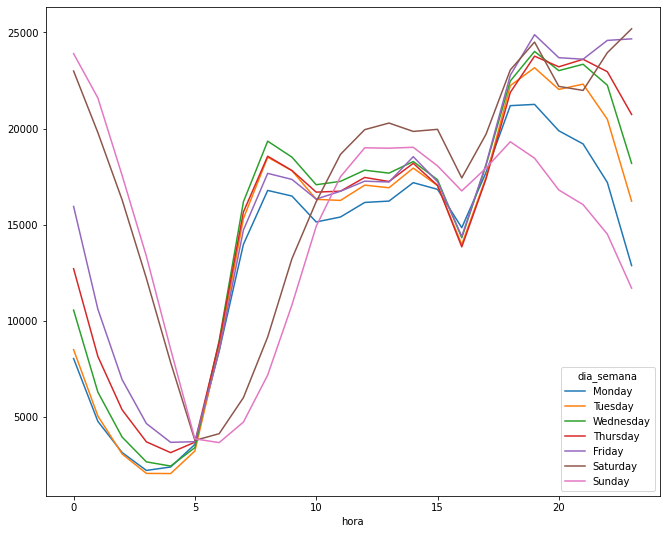

In [68]:
df.groupby(['hora','dia_semana']).mean()['value'].unstack().plot()

In [69]:
#vamos a crear una nueva columa con la media de la agg de hora y dia de semana 
df.join(df.groupby(['hora','dia_semana']).mean()['value'],on=['hora','dia_semana'],rsuffix='_avg')

,timestamp,value,hora,dia_semana,value_avg
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613


In [70]:
new_df=df.join(df.groupby(['hora','dia_semana']).mean()['value'],on=['hora','dia_semana'],rsuffix='_avg')

In [74]:
new_df.to_csv("new_df.csv",index=False)

**Pasamos a detectar las anomalias y vemos si nuestro algoritmo es capaz de detectar dichas anomalias**

In [75]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   5160 non-null   datetime64[ns]
 1   value       5160 non-null   float64       
 2   hora        5160 non-null   int64         
 3   dia_semana  5160 non-null   category      
 4   value_avg   5160 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1)
memory usage: 166.8 KB


In [80]:
#para no hacer el onehoteencoding ni label encoding respecto al dia de semana creamos una columna que tenga el dia de semana pero em int

new_df['dia_s_entero']=new_df.timestamp.dt.weekday

In [81]:
new_df.head()

,timestamp,value,hora,dia_semana,value_avg,dia_s_entero
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1


In [83]:
train=new_df[['hora','value','dia_s_entero']]

In [85]:
modelo=IsolationForest(n_estimators= 150,contamination=0.05,random_state=42,warm_start=False,max_samples=0.8)
modelo.fit(train)

IsolationForest(contamination=0.05, max_samples=0.8, n_estimators=150,
                random_state=42)

In [91]:
#como este alg es no supervisado vamos a crear una nueva columna que sera los valores atipicos de la predicion del modelo
#
# aqui los valores dela pred es 1 o -1 si es 1 no es outlier else si
pd.Series(modelo.predict(train)).unique()

array([ 1, -1])

In [94]:
new_df['outlier']=pd.Series(modelo.predict(train)).apply(lambda x:'si_outlier' if (x==-1) else 'No_outliers')

In [98]:
new_df.query('outlier=="si_outlier"')

,timestamp,value,hora,dia_semana,value_avg,dia_s_entero,outlier
18,2014-07-01 18:00:00,25282.0,18,Tuesday,22233.596774,1,si_outlier
71,2014-07-03 23:00:00,16093.0,23,Thursday,20732.241935,3,si_outlier
81,2014-07-04 09:00:00,7588.5,9,Friday,17348.483871,4,si_outlier
89,2014-07-04 17:00:00,11890.5,17,Friday,18140.758065,4,si_outlier
93,2014-07-04 21:00:00,14028.5,21,Friday,23609.838710,4,si_outlier
...,...,...,...,...,...,...,...
5064,2015-01-28 00:00:00,4751.5,0,Wednesday,10544.661290,2,si_outlier
5065,2015-01-28 01:00:00,2735.0,1,Wednesday,6272.629032,2,si_outlier
5066,2015-01-28 02:00:00,1833.0,2,Wednesday,3931.564516,2,si_outlier
5067,2015-01-28 03:00:00,1289.5,3,Wednesday,2640.241935,2,si_outlier


In [102]:
#vamos a dibujar la serie de tiempo 
#https://plotly.com/python

fig = px.scatter(new_df, x="timestamp", y="value", color="outlier",title='demanda de taxi NYc',hover_data=['hora','dia_semana','value_avg'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [107]:
#vammos a ver la funcion de puntuacion del modelo que decide el umbral depende del caso de uso decidir si el dato es o no atipico 

score=modelo.decision_function(train)



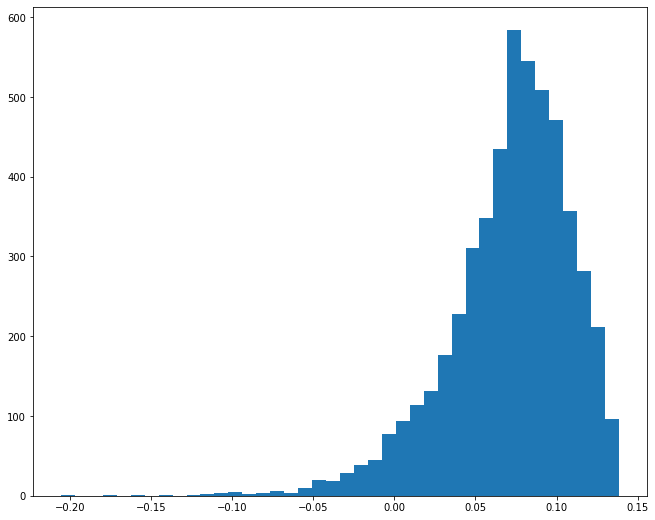

In [109]:
plt.hist(score,bins=40)
plt.show()
#se ve que los datos a atipicos empiezan a partir de -0.02 o mas o menos 

In [111]:
new_df['umbral']=score


In [113]:
new_df.query('umbral<=-0.02')

,timestamp,value,hora,dia_semana,value_avg,dia_s_entero,outlier,umbral
89,2014-07-04 17:00:00,11890.5,17,Friday,18140.758065,4,si_outlier,-0.026704
119,2014-07-05 23:00:00,16698.5,23,Saturday,25192.516129,5,si_outlier,-0.024444
120,2014-07-06 00:00:00,15021.0,0,Sunday,23898.733333,6,si_outlier,-0.048870
121,2014-07-06 01:00:00,12673.0,1,Sunday,21593.533333,6,si_outlier,-0.027408
122,2014-07-06 02:00:00,10139.5,2,Sunday,17555.266667,6,si_outlier,-0.025727
...,...,...,...,...,...,...,...,...
5061,2015-01-27 21:00:00,10819.5,21,Tuesday,22310.741935,1,si_outlier,-0.044864
5062,2015-01-27 22:00:00,9840.0,22,Tuesday,20481.516129,1,si_outlier,-0.061935
5063,2015-01-27 23:00:00,7792.0,23,Tuesday,16217.370968,1,si_outlier,-0.098694
5064,2015-01-28 00:00:00,4751.5,0,Wednesday,10544.661290,2,si_outlier,-0.040225
